# Actividad 3 INFO183

#### Instrucciones generales

- Complete este cuadernillo jupyter con sus códigos y respuestas
- Se trabajará en grupos de tres personas
- Se entrega un cuadernillo por grupo
- La entrega es a través de correo electrónico a phuijse@inf.uach.cl
- La fecha de entrega es el Lunes 6 de Abril a las 23:59
- Use las librerías `scipy`, `numpy` y `matplotlib`

### Nombre completo de los integrantes: 
- A
- B
- C

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np

%matplotlib notebook
from IPython.display import display, Audio, HTML
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import soundfile as sf
import scipy.signal
%matplotlib notebook
from matplotlib import animation, patches
from style import *


NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)

Cannot find path /home/phuijse/.jupyter/nbconfig/, rise configuration wasn't set


#### Enunciado

En esta tarea se pide entrenar y evaluar un predictor para la serie de tiempo Mackey-Glass. Esta serie de tiempo se obtiene de la solución de la siguiente ecuación diferencial

$$
\frac{dy}{dt} = 0.2 \frac{ y(t-\tau)}{1 + y(t-\tau)^{10}} - 0.1 y(t),
$$

donde el parámetro $\tau$ controla el comportamiento dinámico de la serie de tiempo 

***

Use el código que se muestra a continuación para generar la serie de tiempo Mackey Glass

- Considere una razón señal a ruido (SNR) de 2.
- Considere $\tau=17$ (comportamiento debilmente caótico)

Se generaran 1000 muestras de la serie de tiempo. Use los primeros 500 puntos para entrenar y los siguientes 500 puntos para hacer predicción

<IPython.core.display.Javascript object>


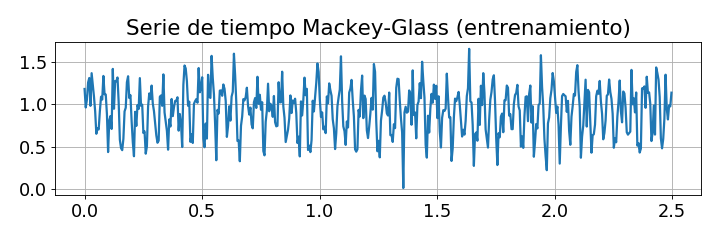

In [2]:
# número de observaciones (no modificar)
N = 1000
# Razón señal a ruido (2., 0.5)
SNR = 2.
# constantes de la ecuación diferencial (no modificar)
a, b = 0.1, 0.2
# comportamiento dinámico de Mackey-Glass (17, 30)
tau = 17.
# paso de integración (no modificar)
dt = 0.05
# condición incial (no modificar)
y0 = 0.9
# largo temporal (no modificar)
tt = 5.
t = np.linspace(0, tt, num=N)

N_full, tau_full = int(N*tt/dt), int(tau/dt)
ymg = y0*np.ones(shape=(N_full, ))
# Runge-Kutta integration
for n in range(tau_full, N_full-1):
    byd = b*ymg[n-tau_full]/(1.0 + ymg[n-tau_full]**10.0)
    yk1 = dt*(-a*ymg[n] + byd)
    yk2 = dt*(-a*(ymg[n]+yk1/2) + byd)
    yk3 = dt*(-a*(ymg[n]+yk2/2) + byd)
    yk4 = dt*(-a*(ymg[n]+yk3) + byd)
    ymg[n+1] = ymg[n] + yk1/6 + yk2/3 +yk3/3 +yk4/6;
ymg = ymg[::int(tt/dt)]
#ymg = ymg - np.mean(ymg) 
# Contaminación con ruido blanco aditivo
s_noise = np.sqrt(np.var(ymg)/SNR) 
np.random.seed(0)
y_obs = ymg + s_noise*np.random.randn(len(ymg))
# Gráfico
fig, ax = plt.subplots(1, figsize=(9, 3), tight_layout=True)
ax.plot(t[:500], y_obs[:500])
ax.set_title('Serie de tiempo Mackey-Glass (entrenamiento)');

***

1. Describa en detalle el algoritmo LMS indicando sus semejanzas y diferencias con el filtro de Wiener

   


1. Partiendo del error instantaneo $J_n^s(\textbf{w}) = e_n^2$ derive la regla de actualización de pesos
1. La siguiente clase de *Python* predice y entrena un filtro LMS. Complete la línea que dice 

` self.w = ? `

con el valor correcto de actualización de peso del filtro LMS

# Desarrollo
1. Describa en detalle el algoritmo LMS indicando sus semejanzas y diferencias con el filtro de Wiener

 - El algoritmo LMS es usado en filtros adaptativos, para encontrar el filtro que permiten obtener el valor esperado mínimo del cuadrado de la señal de error, que es considerada como la diferencia entre la señal deseada y la señal producida a la salida del filtro. 

    - Pertenece a la familia de algoritmos de gradiente estocástico. 
        Es un algoritmo facil de implementar, ya que no requiere medidas tales como la inversión de la matriz de correlación ni funciones de correlación. 

    El algoritmo LMS es un algoritmo de filtrado lineal adaptativo, que, en general, consiste de dos fases: 
    - Proceso de filtrado (Computo de la salida de un filtro en función de su entrada y estimaciones de error)
    - Proceso adaptativo (Ajuste automático de los parametros del filtro de acuerdo a su estimación de error). 

    SEMEJANZAS:

    - El algoritmo LMS converge con la solución del filtro de Wiener, suponiendo que el sistema desconocido es LTI y el sistema es estacionario. 

    - Los dos filtros sirven para identificar la respuesta a un sistema desconocido, conociendo solo la señal de entrada original y la salida del sistema desconocido. 

    DIFERENCIAS: 

    - El filtro de Wiener se parece mucho a la estimación de minimos cuadrados, excepto en el dominio de procesamiento de señales.
    - A diferencia del filtro de Wiener no se require conocimiento estadistico del proceso. 
    - LMS se actualiza online y tiene costo $L$. Wiener se entrena offline y tiene costo $L^2$.
    - En el algoritmo LMS no se requiere invertir la matriz de correlación.
    - Wiener es optimo mientras que LMS es sub-optimo. 
    
    
1. Partiendo del error instantaneo $J_n^s(\textbf{w}) = e_n^2$ derive la regla de actualización de pesos
$$
\begin{align}
J^s_n(\textbf{w}) &= e_n^2 \nonumber \\
&= (d_n - y_n)^2 \nonumber \\
&= (d_n - \textbf{w}^T \textbf{u}_n )^2 \nonumber \\
&= (d_n - \sum_{k=0}^{L} w_{n, k} u_{n-k} )^2 \nonumber 
\end{align}
$$
El gradiente en funcion a sus pesos es
$$
\frac{d J^s_n (\textbf{w})}{d w_{n, k}} = - 2 e_n u_{n-k}
$$
Usando la regla SGD llegamos a 
$$
w_{n+1, k} = w_{n, k} + 2 \mu e_n u_{n-k}, k=0, 1, \ldots, L
$$
o en forma matricial
$$
\begin{align}
\textbf{w}_{n+1} &= \textbf{w}_{n} + 2 \mu e_n \textbf{u}_{n}\nonumber \\
&= \textbf{w}_{n} + 2 \mu (d_n -  \textbf{w}_{n}^T \textbf{u}_{n}) \textbf{u}_{n}, \nonumber 
\end{align}
$$




In [2]:
class LMS_filter(object):
    
    def __init__(self, L=1, mu=0.5, normalized=True):
        self.L = L
        self.mu = mu
        self.w = np.zeros(shape=(L, ))
        self.normalized = normalized
    
    def __len__(self):
        return self.L
    
    def predict(self, u):
        return np.dot(self.w, u)
    
    def update(self, u, d):
        d_pred = self.predict(u)
        norm = 1.
        if self.normalized:
            norm = np.sum(u**2) + 1e-6
        self.w = self.w + 2*self.mu*(d -d_pred)*u/norm #se agrego 2*self.mu*(d -d_pred)*u/norm 


***
## Predicción con algoritmo LMS

1. Entrene el predictor con el algoritmo normalized LMS usando el siguiente bloque de código
1. Construya una tabla con los NMSE de entrenamiento y prueba para distintos valores de $\mu$ y $L$
    - Se recomienda hacer un barrido logarítmico en $\mu$ (por ejemplo `mu=np.logspace(-2, 0, num=20)`)
    - Use al menos los siguientes valores de $L$: [5, 10, 20, 30]
1. Describa cada experimento analizando sus resultados de forma cuantitativa y cualitativa
    - ¿Se sobreajuste el filtro a los datos de entrenamiento? 
    - ¿Se desestabiliza el filtro?
1. Indique que combinación obtiene menor MSE de prueba 
***

1. Repita el experimento para $\tau = 30$ (comportamiento fuertemente caótico) 
1. Compare los resultados obtenidos con cada serie de tiempo. ¿Qué casos son más sencillos y cuales más complicados?


In [4]:
#Cuando Tau es 17

N = 1000;SNR = 2.;a, b = 0.1, 0.2;tau = 17.;dt = 0.05;y0 = 0.9;tt = 5.;t = np.linspace(0, tt, num=N)
N_full, tau_full = int(N*tt/dt), int(tau/dt)
ymg = y0*np.ones(shape=(N_full, ))
# Runge-Kutta integration
for n in range(tau_full, N_full-1):
    byd = b*ymg[n-tau_full]/(1.0 + ymg[n-tau_full]**10.0)
    yk1 = dt*(-a*ymg[n] + byd)
    yk2 = dt*(-a*(ymg[n]+yk1/2) + byd)
    yk3 = dt*(-a*(ymg[n]+yk2/2) + byd)
    yk4 = dt*(-a*(ymg[n]+yk3) + byd)
    ymg[n+1] = ymg[n] + yk1/6 + yk2/3 +yk3/3 +yk4/6;
ymg = ymg[::int(tt/dt)]
#ymg = ymg - np.mean(ymg) 
# Contaminación con ruido blanco aditivo
s_noise = np.sqrt(np.var(ymg)/SNR) 
np.random.seed(0)
y_obs = ymg + s_noise*np.random.randn(len(ymg))

def update(L, mu):
    lms = LMS_filter(L, mu, normalized=True)
    
    # Entrenamiento
    y_pred = np.zeros(shape=(len(y_obs), ))
    for k in range(lms.__len__(), 500):
        y_window = y_obs[k-lms.__len__():k]
        y_pred[k] = lms.predict(y_window)
        lms.update(d=y_obs[k], u=y_window)
        
    # Prueba
    for k in range(500, len(y_obs)):
        y_window = y_obs[k-lms.__len__():k]
        y_pred[k] = lms.predict(y_window)

    print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[lms.__len__():500], y_pred[lms.__len__():500]), 
                                                    NMSE(ymg[500:], y_pred[500:])))
    fig, ax = plt.subplots(3, figsize=(12, 10), tight_layout=True)
    ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
    ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
    ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
    ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

    ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
    ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend(); 

interact(update, L=SelectionSlider_nice(options=[5, 10, 20, 30], value=5), mu=np.logspace(-2,0,num=20));


interactive(children=(SelectionSlider(continuous_update=False, description='L', layout=Layout(height='20px', w…

In [5]:
N = 1000;SNR = 2.;a, b = 0.1, 0.2;dt = 0.05;y0 = 0.9;tt = 5.;t = np.linspace(0, tt, num=N)
LV = [5,10,20,30];muV = np.logspace(-2, 0, num=20)
tau=17;
N_full, tau_full = int(N*tt/dt), int(tau/dt)
ymg = y0*np.ones(shape=(N_full, ))
for n in range(tau_full, N_full-1):
    byd = b*ymg[n-tau_full]/(1.0 + ymg[n-tau_full]**10.0)
    yk1 = dt*(-a*ymg[n] + byd)
    yk2 = dt*(-a*(ymg[n]+yk1/2) + byd)
    yk3 = dt*(-a*(ymg[n]+yk2/2) + byd)
    yk4 = dt*(-a*(ymg[n]+yk3) + byd)
    ymg[n+1] = ymg[n] + yk1/6 + yk2/3 +yk3/3 +yk4/6;
ymg = ymg[::int(tt/dt)]
s_noise = np.sqrt(np.var(ymg)/SNR) 
np.random.seed(0)
y_obs = ymg + s_noise*np.random.randn(len(ymg))

#For para L=5,10,20,30
for j in range(0,4):
    print("------------------------------------------------------------------")  
    print("L = ",LV[j])
    print("------------------------------------------------------------------")  
    #For para cada valor de mu
    for u in range(0,20):
        lms = LMS_filter(LV[j], muV[u], normalized=True)
        # Entrenamiento
        y_pred = np.zeros(shape=(len(y_obs), ))
        for k in range(lms.__len__(), 500):
            y_window = y_obs[k-lms.__len__():k]
            y_pred[k] = lms.predict(y_window)
            lms.update(d=y_obs[k], u=y_window)
        # Prueba
        for k in range(500, len(y_obs)):
            y_window = y_obs[k-lms.__len__():k]
            y_pred[k] = lms.predict(y_window)
        print("mu = ", muV[u],"         MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[lms.__len__():500], y_pred[lms.__len__():500]), 
                                                    NMSE(ymg[500:], y_pred[500:])))
   

------------------------------------------------------------------
L =  5
------------------------------------------------------------------
mu =  0.01          MSE entrenamiento 1227.8754, prueba 772.8594
mu =  0.012742749857031334          MSE entrenamiento 1136.9204, prueba 737.4738
mu =  0.016237767391887217          MSE entrenamiento 1058.8728, prueba 699.6373
mu =  0.0206913808111479          MSE entrenamiento 990.5780, prueba 660.8372
mu =  0.026366508987303583          MSE entrenamiento 930.7635, prueba 622.7582
mu =  0.03359818286283781          MSE entrenamiento 879.2813, prueba 587.1804
mu =  0.04281332398719394          MSE entrenamiento 836.2880, prueba 555.9065
mu =  0.0545559478116852          MSE entrenamiento 801.8955, prueba 530.8906
mu =  0.06951927961775606          MSE entrenamiento 776.4186, prueba 514.4887
mu =  0.08858667904100823          MSE entrenamiento 760.8722, prueba 509.4670
mu =  0.11288378916846889          MSE entrenamiento 757.2789, prueba 518.4717
m

# ANALISIS 

### Para $\tau = 17$

### L = 5
- Este filtro posee el peor sobreajuste de entrenamiento de todos con un valor maximo de MSE = 123371.8084, con respecto a la estabilidad se mantiene bien pero tiende a desastabili

### L = 10
- hola

### L = 20
- hola

### L = 30
- hola

Indique que combinación obtiene menor MSE de prueba 

In [6]:
#Cuando Tau es 30

N = 1000;SNR = 2.;a, b = 0.1, 0.2;tau = 30.;dt = 0.05;y0 = 0.9;tt = 5.;t = np.linspace(0, tt, num=N)
N_full, tau_full = int(N*tt/dt), int(tau/dt)
ymg = y0*np.ones(shape=(N_full, ))
# Runge-Kutta integration
for n in range(tau_full, N_full-1):
    byd = b*ymg[n-tau_full]/(1.0 + ymg[n-tau_full]**10.0)
    yk1 = dt*(-a*ymg[n] + byd)
    yk2 = dt*(-a*(ymg[n]+yk1/2) + byd)
    yk3 = dt*(-a*(ymg[n]+yk2/2) + byd)
    yk4 = dt*(-a*(ymg[n]+yk3) + byd)
    ymg[n+1] = ymg[n] + yk1/6 + yk2/3 +yk3/3 +yk4/6;
ymg = ymg[::int(tt/dt)]
#ymg = ymg - np.mean(ymg) 
# Contaminación con ruido blanco aditivo
s_noise = np.sqrt(np.var(ymg)/SNR) 
np.random.seed(0)
y_obs = ymg + s_noise*np.random.randn(len(ymg))

def update(L, mu):
    lms = LMS_filter(L, mu, normalized=True)
    
    # Entrenamiento
    y_pred = np.zeros(shape=(len(y_obs), ))
    for k in range(lms.__len__(), 500):
        y_window = y_obs[k-lms.__len__():k]
        y_pred[k] = lms.predict(y_window)
        lms.update(d=y_obs[k], u=y_window)
        
    # Prueba
    for k in range(500, len(y_obs)):
        y_window = y_obs[k-lms.__len__():k]
        y_pred[k] = lms.predict(y_window)

    print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[lms.__len__():500], y_pred[lms.__len__():500]), 
                                                    NMSE(ymg[500:], y_pred[500:])))
    fig, ax = plt.subplots(3, figsize=(12, 10), tight_layout=True)
    ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
    ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
    ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
    ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

    ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
    ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend(); 

interact(update, L=SelectionSlider_nice(options=[5, 10, 20, 30], value=5), mu=np.logspace(-2,0,num=20));

interactive(children=(SelectionSlider(continuous_update=False, description='L', layout=Layout(height='20px', w…

In [7]:
N = 1000;SNR = 2.;a, b = 0.1, 0.2;dt = 0.05;y0 = 0.9;tt = 5.;t = np.linspace(0, tt, num=N)
LV = [5,10,20,30];muV = np.logspace(-2, 0, num=20)
tau=30;
N_full, tau_full = int(N*tt/dt), int(tau/dt)
ymg = y0*np.ones(shape=(N_full, ))
for n in range(tau_full, N_full-1):
    byd = b*ymg[n-tau_full]/(1.0 + ymg[n-tau_full]**10.0)
    yk1 = dt*(-a*ymg[n] + byd)
    yk2 = dt*(-a*(ymg[n]+yk1/2) + byd)
    yk3 = dt*(-a*(ymg[n]+yk2/2) + byd)
    yk4 = dt*(-a*(ymg[n]+yk3) + byd)
    ymg[n+1] = ymg[n] + yk1/6 + yk2/3 +yk3/3 +yk4/6;
ymg = ymg[::int(tt/dt)]
s_noise = np.sqrt(np.var(ymg)/SNR) 
np.random.seed(0)
y_obs = ymg + s_noise*np.random.randn(len(ymg))

#For para L=5,10,20,30
for j in range(0,4):
    print("------------------------------------------------------------------")  
    print("L = ",LV[j])
    print("------------------------------------------------------------------")  
    #For para cada valor de mu
    for u in range(0,20):
        lms = LMS_filter(LV[j], muV[u], normalized=True)
        # Entrenamiento
        y_pred = np.zeros(shape=(len(y_obs), ))
        for k in range(lms.__len__(), 500):
            y_window = y_obs[k-lms.__len__():k]
            y_pred[k] = lms.predict(y_window)
            lms.update(d=y_obs[k], u=y_window)
        # Prueba
        for k in range(500, len(y_obs)):
            y_window = y_obs[k-lms.__len__():k]
            y_pred[k] = lms.predict(y_window)
        print("mu = ", muV[u],"         MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[lms.__len__():500], y_pred[lms.__len__():500]), 
                                                    NMSE(ymg[500:], y_pred[500:])))
   
        

------------------------------------------------------------------
L =  5
------------------------------------------------------------------
mu =  0.01          MSE entrenamiento 757.4389, prueba 484.9377
mu =  0.012742749857031334          MSE entrenamiento 703.7113, prueba 468.7517
mu =  0.016237767391887217          MSE entrenamiento 657.6870, prueba 451.3337
mu =  0.0206913808111479          MSE entrenamiento 617.5358, prueba 433.0441
mu =  0.026366508987303583          MSE entrenamiento 582.7191, prueba 414.3721
mu =  0.03359818286283781          MSE entrenamiento 553.5161, prueba 396.2067
mu =  0.04281332398719394          MSE entrenamiento 530.4951, prueba 379.8964
mu =  0.0545559478116852          MSE entrenamiento 514.2187, prueba 367.0700
mu =  0.06951927961775606          MSE entrenamiento 505.2229, prueba 359.4268
mu =  0.08858667904100823          MSE entrenamiento 504.1223, prueba 359.1824
mu =  0.11288378916846889          MSE entrenamiento 511.8028, prueba 371.1293
mu =

# ANALISIS 

### Para $\tau = 30$

### L = 5
- hola

### L = 10
- hola

### L = 20
- hola

### L = 30
- hola

Indique que combinación obtiene menor MSE de prueba 

In [20]:
#UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU 
#UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU 
#UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU 
#UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU 
#UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU 
#UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU 
#UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU UWU 


***
## Predicción con algoritmo RLS

1. Describa en detalle el algoritmo RLS indicando sus semejanzas y diferencias con el algoritmo LMS
1. Partiendo del error histórico $J_N(\textbf{w}) = \sum_{i=1}^N \beta^{N-i} e_i^2$ derive la regla recursiva de actualización de pesos 
1. La siguiente clase de *Python* predice y entrena un filtro RLS. Complete las líneas que dice 

` self.w = ? ` y `self.Phi_inv = ?`

con el valor correcto de actualización de peso del filtro RLS

In [14]:
class RLS_filter(object):
    
    def __init__(self, L=1, beta=0.9, delta=10.):
        self.L = L
        self.beta = beta
        self.w = np.zeros(shape=(L, ))
        self.Phi_inv = delta*np.eye(L)
    
    def __len__(self):
        return self.L
    
    def predict(self, u):
        return np.dot(self.w, u)
    
    def update(self, u, d):          
        invbeta = 1.0/self.beta
        d_pred = self.predict(u)
        e = d - d_pred
        r = 1. + invbeta*np.dot(np.dot(u, self.Phi_inv), u.T)
        k = invbeta*np.dot(self.Phi_inv, u)/r       
        self.Phi_inv =  invbeta * (1.0 - np.sum(k * u.T))* self.Phi_inv
        self.w =  self.w + np.dot(k, e)
        

SyntaxError: invalid syntax (<ipython-input-14-93393a4dd763>, line 21)

***

1. Entrene el predictor con el algoritmo RLS usando el siguiente bloque de código
1. Considere primero  $\tau=17$
1. Construya una tabla con los NMSE de entrenamiento y prueba para distintos valores de $\beta$ y $L$
    - Se recomienda hacer un barrido lineal en $\beta$ (por ejemplo `mu=np.linspace(0.8, 1.0, num=20)`)
    - Use al menos los siguientes valores de $L$: [5, 10, 20, 30]
1. Describa cada experimento analizando sus resultados de forma cuantitativa y cualitativa
    - ¿Cuánto demora el filtro en estabilizarse? 
    - ¿Se sobreajuste el filtro a los datos de entrenamiento? 
    - ¿Se desestabiliza el filtro?
1. Indique que combinación obtiene menor MSE de prueba 
1. Repita el experimento para $\tau=30$
1. Compare con los resultados obtenidos con el algoritmo LMS ¿Qué algoritmo demora menos en converger?


In [13]:
rls = RLS_filter(L=30, beta=0.9, delta=1.)
# Entrenamiento
y_pred = np.zeros(shape=(len(y_obs), ))
for k in range(rls.__len__(), 500):
    y_window = y_obs[k-rls.__len__():k]
    rls.update(d=y_obs[k], u=y_window)
    y_pred[k] = rls.predict(y_window)
# Prueba
for k in range(500, len(y_obs)):
    y_window = y_obs[k-rls.__len__():k]
    y_pred[k] = rls.predict(y_window)
    
print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[rls.__len__():500], y_pred[rls.__len__():500]), 
                                                NMSE(ymg[500:], y_pred[500:])))

NameError: name 'RLS_filter' is not defined

<IPython.core.display.Javascript object>


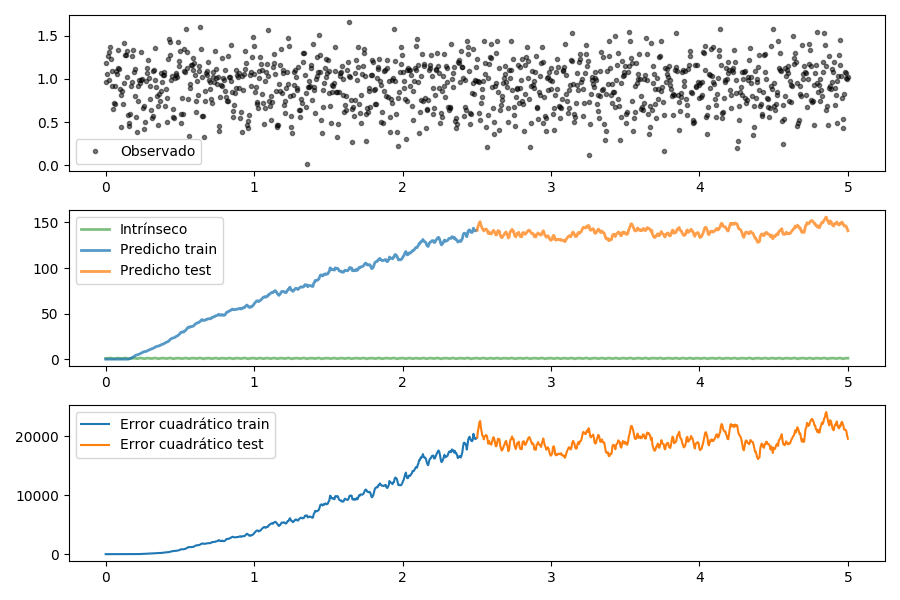

In [15]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend(); 

NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)